In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
import matplotlib.pyplot as plt
import operator
from functools import reduce
from functools import partial
from timeit import default_timer
from utilities3 import *
from Adam import Adam
from scipy import integrate
from fourier_1d import *
from scipy.stats import multivariate_normal

In [2]:
x_data = np.load('data/spde_1_x.npy')
y_data = np.load('data/spde_1_y.npy')

In [3]:
x_grid = np.linspace(0, 1, x_data.shape[-1])

ntrain = 900
ntest = 100

batch_size = 50
learning_rate = 0.001

epochs = 500
step_size = 50
gamma = 0.5

modes = 16
width = 64

x_train = x_data[:ntrain,::5]
y_train = y_data[:ntrain,::5]
x_test = x_data[-ntest:,::5]
y_test = y_data[-ntest:,::5]
x_grid = x_grid[::5]

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train)
x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test)


x_train = torch.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_test = torch.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_train, y_train), batch_size=batch_size, shuffle=True)

model = FNO1d(modes, width).cuda()
print('Total parameters:',count_params(model))

optimizer = Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

start = default_timer()

MSE = torch.zeros(epochs)
L2 = torch.zeros(epochs)

myloss = LpLoss(size_average=False)
for ep in range(epochs):
    model.train()
    t1 = default_timer()
    train_mse = 0
    train_l2 = 0
    for x, y in train_loader:
        x, y = x.cuda(), y.cuda()

        optimizer.zero_grad()
        out = model(x)
        mse = F.mse_loss(out.view(batch_size, -1), y.view(batch_size, -1), reduction='mean')
        l2 = myloss(out.view(batch_size, -1), y.view(batch_size, -1))
        l2.backward()
        
        optimizer.step()
        train_mse += mse.item()
        train_l2 += l2.item()
        
    scheduler.step()
    
    train_mse /= len(train_loader)
    train_l2 /= ntrain
    t2 = default_timer()
    
    MSE[ep] = train_mse
    L2[ep] = train_l2
    print('\repoch {:d}/{:d} L2 = {:.6f}, MSE = {:.6f}, using {:.6f}s'.format(ep+1,epochs,train_l2,train_mse,t2-t1), end='\n', flush=True)

print('Total training time:',default_timer()-start,'s')

Total parameters: 549569
epoch 1/500 L2 = 0.926531, MSE = 1.970027, using 2.602981s
epoch 2/500 L2 = 0.622796, MSE = 0.560012, using 0.131593s
epoch 3/500 L2 = 0.445561, MSE = 0.244708, using 0.123577s
epoch 4/500 L2 = 0.273304, MSE = 0.076056, using 0.123066s
epoch 5/500 L2 = 0.126426, MSE = 0.033598, using 0.122992s
epoch 6/500 L2 = 0.077331, MSE = 0.015532, using 0.121378s
epoch 7/500 L2 = 0.057960, MSE = 0.011810, using 0.122371s
epoch 8/500 L2 = 0.046527, MSE = 0.007809, using 0.121718s
epoch 9/500 L2 = 0.074685, MSE = 0.010028, using 0.122029s
epoch 10/500 L2 = 0.056529, MSE = 0.009569, using 0.121336s
epoch 11/500 L2 = 0.103164, MSE = 0.020781, using 0.120199s
epoch 12/500 L2 = 0.056420, MSE = 0.007998, using 0.124506s
epoch 13/500 L2 = 0.041091, MSE = 0.005811, using 0.121739s
epoch 14/500 L2 = 0.040856, MSE = 0.005343, using 0.121951s
epoch 15/500 L2 = 0.038266, MSE = 0.004445, using 0.124540s
epoch 16/500 L2 = 0.040695, MSE = 0.004003, using 0.124919s
epoch 17/500 L2 = 0.0499

epoch 137/500 L2 = 0.013250, MSE = 0.000441, using 0.121603s
epoch 138/500 L2 = 0.010353, MSE = 0.000316, using 0.125526s
epoch 139/500 L2 = 0.010518, MSE = 0.000378, using 0.129739s
epoch 140/500 L2 = 0.006608, MSE = 0.000268, using 0.124660s
epoch 141/500 L2 = 0.007003, MSE = 0.000275, using 0.126958s
epoch 142/500 L2 = 0.006877, MSE = 0.000264, using 0.127675s
epoch 143/500 L2 = 0.009339, MSE = 0.000397, using 0.134007s
epoch 144/500 L2 = 0.012371, MSE = 0.000458, using 0.130904s
epoch 145/500 L2 = 0.008488, MSE = 0.000363, using 0.140447s
epoch 146/500 L2 = 0.008403, MSE = 0.000282, using 0.124051s
epoch 147/500 L2 = 0.007938, MSE = 0.000267, using 0.126983s
epoch 148/500 L2 = 0.009866, MSE = 0.000353, using 0.119185s
epoch 149/500 L2 = 0.008370, MSE = 0.000261, using 0.124085s
epoch 150/500 L2 = 0.009699, MSE = 0.000341, using 0.123445s
epoch 151/500 L2 = 0.010424, MSE = 0.000424, using 0.124240s
epoch 152/500 L2 = 0.007330, MSE = 0.000266, using 0.122549s
epoch 153/500 L2 = 0.006

epoch 272/500 L2 = 0.002960, MSE = 0.000119, using 0.220828s
epoch 273/500 L2 = 0.002739, MSE = 0.000116, using 0.217507s
epoch 274/500 L2 = 0.002876, MSE = 0.000120, using 0.213220s
epoch 275/500 L2 = 0.003578, MSE = 0.000115, using 0.220063s
epoch 276/500 L2 = 0.004081, MSE = 0.000124, using 0.237485s
epoch 277/500 L2 = 0.003600, MSE = 0.000119, using 0.225864s
epoch 278/500 L2 = 0.003203, MSE = 0.000119, using 0.229693s
epoch 279/500 L2 = 0.002695, MSE = 0.000115, using 0.223948s
epoch 280/500 L2 = 0.002683, MSE = 0.000113, using 0.224387s
epoch 281/500 L2 = 0.002523, MSE = 0.000111, using 0.215102s
epoch 282/500 L2 = 0.002577, MSE = 0.000113, using 0.233134s
epoch 283/500 L2 = 0.002556, MSE = 0.000114, using 0.222295s
epoch 284/500 L2 = 0.002706, MSE = 0.000114, using 0.224615s
epoch 285/500 L2 = 0.002965, MSE = 0.000114, using 0.239466s
epoch 286/500 L2 = 0.002567, MSE = 0.000113, using 0.225742s
epoch 287/500 L2 = 0.002461, MSE = 0.000112, using 0.218652s
epoch 288/500 L2 = 0.002

epoch 407/500 L2 = 0.002087, MSE = 0.000099, using 0.215741s
epoch 408/500 L2 = 0.002108, MSE = 0.000099, using 0.227718s
epoch 409/500 L2 = 0.002108, MSE = 0.000099, using 0.223815s
epoch 410/500 L2 = 0.002096, MSE = 0.000100, using 0.236495s
epoch 411/500 L2 = 0.002077, MSE = 0.000099, using 0.210684s
epoch 412/500 L2 = 0.002083, MSE = 0.000099, using 0.231249s
epoch 413/500 L2 = 0.002096, MSE = 0.000099, using 0.222320s
epoch 414/500 L2 = 0.002153, MSE = 0.000100, using 0.230379s
epoch 415/500 L2 = 0.002087, MSE = 0.000099, using 0.226374s
epoch 416/500 L2 = 0.002096, MSE = 0.000099, using 0.226000s
epoch 417/500 L2 = 0.002072, MSE = 0.000099, using 0.218201s
epoch 418/500 L2 = 0.002096, MSE = 0.000099, using 0.218044s
epoch 419/500 L2 = 0.002100, MSE = 0.000099, using 0.216925s
epoch 420/500 L2 = 0.002101, MSE = 0.000099, using 0.226035s
epoch 421/500 L2 = 0.002092, MSE = 0.000098, using 0.223203s
epoch 422/500 L2 = 0.002114, MSE = 0.000099, using 0.229634s
epoch 423/500 L2 = 0.002

In [4]:
pred = torch.zeros(y_test.shape)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(x_test, y_test), batch_size=1, shuffle=False)
index = 0
test_l2 = 0
test_mse = 0
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.cuda(), y.cuda()

        out = model(x).view(-1)
        pred[index] = out
        mse = F.mse_loss(out.view(1, -1), y.view(1, -1), reduction='mean')
        test_l2 += myloss(out.view(1, -1), y.view(1, -1)).item()
        test_mse += mse.item()
        index += 1
        
    test_mse /= len(test_loader)
    test_l2 /= ntest
    print('test error: L2 =', test_l2,', MSE =',test_mse)

test error: L2 = 0.002721742214052938 , MSE = 6.212843583803363e-05


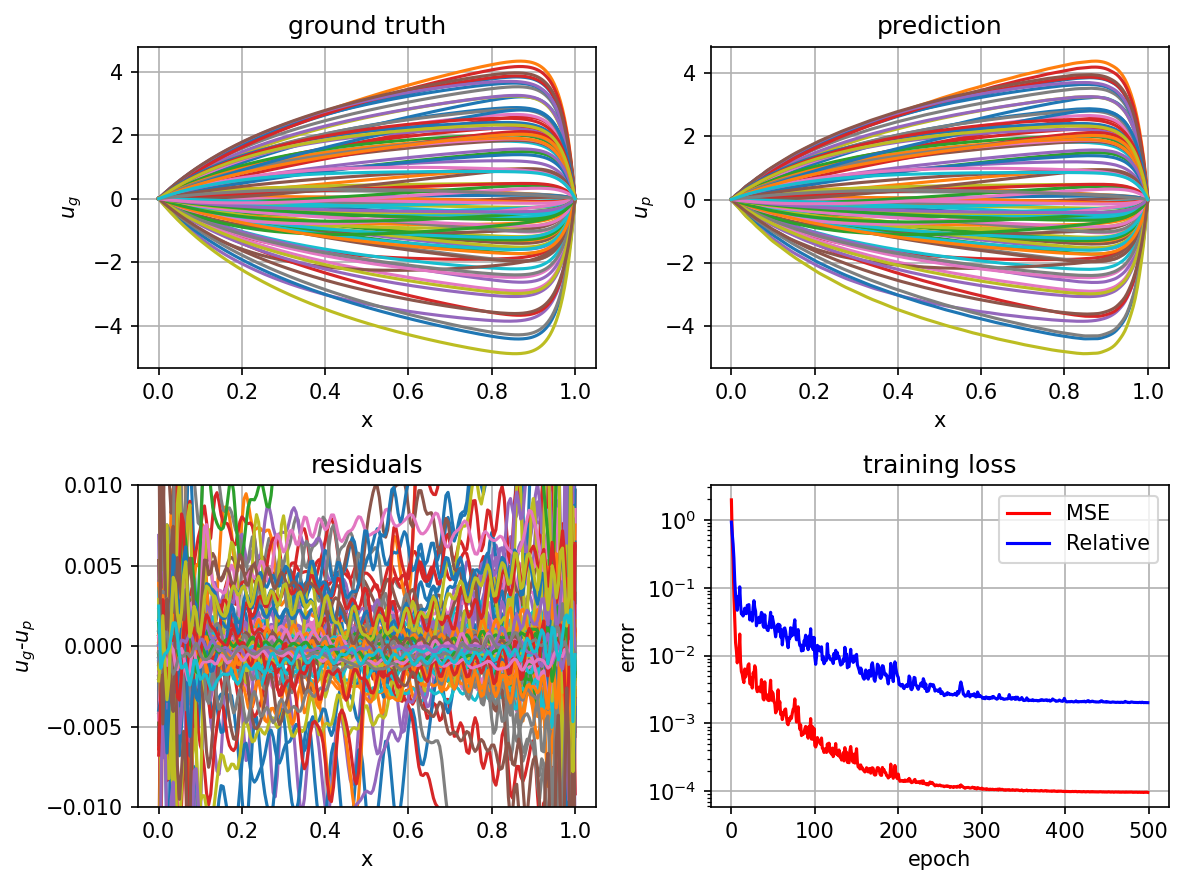

In [5]:
residual = pred-y_test
fig = plt.figure(figsize=(8,6),dpi=150)

plt.subplot(2,2,1)
plt.title("ground truth")
for i in range(ntest):
    plt.plot(x_grid,y_test[i])
plt.xlabel("x")
plt.ylabel("$u_g$")
plt.grid()

plt.subplot(2,2,2)
plt.title("prediction")
for i in range(ntest):
    plt.plot(x_grid,pred[i])
plt.xlabel("x")
plt.ylabel("$u_p$")
plt.grid()

plt.subplot(2,2,3)
plt.title("residuals")
plt.ylim([-0.01,0.01])
for i in range(ntest):
    plt.plot(x_grid,residual[i])
plt.xlabel("x")
plt.ylabel("$u_g$-$u_p$")
plt.grid()
    
plt.subplot(2,2,4)
plt.title("training loss")
plt.plot(MSE,c='r',label='MSE')
plt.plot(L2,c='b',label='Relative')
plt.legend()
plt.yscale('log')
plt.xlabel("epoch")
plt.ylabel("error")
plt.grid()

plt.tight_layout()
plt.show()

In [6]:
v = torch.zeros(ntest)
m = torch.zeros(ntest)
for i in range(ntest):
    v[i] = torch.var(residual[i],unbiased=False)
    m[i] = torch.mean(residual[i])
print(torch.mean(m),torch.mean(v))

tensor(0.0010) tensor(2.5166e-05)


In [7]:
mse = MSE.numpy().reshape(1,MSE.shape[0])
l2 = L2.numpy().reshape(1,L2.shape[0])
loss = np.concatenate((mse,l2))
np.save("data/fno_loss_1.npy",loss)
torch.save(model,"model/fno_1")